<a href="https://colab.research.google.com/github/anitamezzetti/financial_big_data/blob/main/granger_causality_world.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
student1 = "Anita Mezzetti"
student2 = "Hien Lê"

Complementary stuff:
* Drive Folder to save data, notebooks and models

Note: project has been linked to [Github](https://github.com/anitamezzetti/financial_big_data)!

In [2]:
from google.colab import drive
import os, sys

drive.mount('/content/drive')
#nb_path = '/content/notebooks2'
#os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
#sys.path.insert(0,nb_path)

#!pip install --target=$nb_path arrow

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls "/content/drive/My Drive/Colab Notebooks" # checking the content of the folder

 AnitaVersion_FinBigData_1.ipynb
 arrow
 arrow-0.17.0.dist-info
 AUS.csv
 AUT.csv
 BEL.csv
 BRA.csv
 CAN.csv
 CHE.csv
 CHN.csv
 classification_3.ipynb
'classification_4 (1).ipynb'
 classification_4.ipynb
 classification.ipynb
 closed_form_solution.ipynb
'complete_mc (1).ipynb'
'complete_mc (2).ipynb'
 complete_mc.ipynb
'Copia di mc.ipynb'
 CZE.csv
 dateutil
 DEU.csv
 DNK.csv
 ESP.csv
 FIN.csv
 FRA.csv
 GBR.csv
 generate_dataset_dataset4.ipynb
 generate_dataset_fixedK_movingS0.ipynb
 generate_dataset.ipynb
 GHA.csv
'granger_causality_many_cuntries (1).ipynb'
 granger_causality_many_cuntries.ipynb
 granger_causality_world.ipynb
 GRC.csv
'Heston_Project (1).ipynb'
'Heston_Project (2).ipynb'
 Heston_Project.ipynb
 HRV.csv
 IRL.csv
 ITA.csv
 JPN.csv
 NLD.csv
 notebooks2
 NZL.csv
 POL.csv
 PRT.csv
 __pycache__
 python_dateutil-2.8.1.dist-info
 RUS.csv
 six-1.15.0.dist-info
 six.py
 SWE.csv
 THA.csv
 Untitled
'Untitled (1)'
 USA.csv


In [4]:
root = "/content/drive/My Drive/Colab Notebooks" 

In [5]:
!pip install arrow

In [6]:
!pip install ipynb

## Data

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import networkx as nx
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
import ipynb 

# other libraries here
import requests
import arrow

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Import functions for granger causality

In [8]:
from ipynb.fs.full.granger_causality_functions import make_stationary, grangers_causality_matrix, network_granger, granger_causality

In [9]:
# The following snippet gets data for the 4 countries from a proxy API, but it seems that the database in this API is not up-to-date
# jh_data = requests.get('https://covid19api.herokuapp.com/confirmed')

# res_dict = jh_data.json()["locations"]
# df_res = pd.json_normalize(res_dict)
# df_res = df_res.drop(columns=["country_code", "latest", "province", "coordinates.latitude", "coordinates.longitude"])

# countries_of_interest = ["US", "Switzerland", "Japan", "China"]

# df_china = df_res[df_res.country == "China"].set_index("country")
# df_china = pd.DataFrame(df_china.sum(axis=0), columns=["China"]).T

# df = df_res[df_res.country.isin(countries_of_interest[:3])].set_index("country")
# df = pd.concat([df, df_china])

In [10]:
countries_of_interest = ["USA", "CHE", "JPN", "CHN", "ITA", "FRA"]

countries_of_interest_world = ["USA", "CHE", "JPN", "CHN", "ITA", "FRA", "CAN", "ESP", 
                         "BRA", "AUS", "NZL", "RUS", "GBR", "GHA", "THA", "DEU"]


countries_of_interest_eu = ["AUT", "BEL", "HRV", "DNK", "FIN", "FRA",
                                "DEU", "IRL", "ITA", "NLD", "POL", "PRT",
                                "ESP", "SWE", "GBR"]

endpoint = "https://covidapi.info/api/v1" # endpoint that provides JHU data
start_date = "2020-01-1"
end_date = "2020-12-01" # yesterday
dfs = {} # dfs of cumulative confirmed cases
for country in countries_of_interest:
  query = f"{endpoint}/country/{country}/timeseries/{start_date}/{end_date}"
  res = requests.get(query).json()
  df = pd.DataFrame(res["result"])
  df.index = pd.DatetimeIndex(df["date"], tz="utc")
  df.drop(columns=["date"])
  df["date"] = pd.to_datetime(df["date"])
  df["ts_in_secs"] = df["date"].astype(int)
  df["new_confirmed"] = df["confirmed"].diff().fillna(0)
  df.to_csv(f"{root}/{country}.csv")
  dfs[country] = df

## Analysis

In [11]:
# dataset for confirmed cases for each country (needed later)
df_confirmed = pd.DataFrame(index = dfs[country].index)
df_total = pd.DataFrame(index = dfs[country].index)

In [12]:
# first overview
for country,df in dfs.items():  
    df_confirmed[country] = df["new_confirmed"] 
    df_total[country] = df["confirmed"]

## Study New Cases

Normalize data

In [13]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df_confirmed.values)
df_confirmed_scaled = pd.DataFrame(x_scaled)

map = {}
for i in range(len(countries_of_interest)):
    map[i] = countries_of_interest[i]

df_confirmed_scaled = df_confirmed_scaled.rename(columns=map)
df_confirmed_scaled['Date'] = df_confirmed.index
df_confirmed_scaled = df_confirmed_scaled.set_index('Date')
df_confirmed_scaled.head()

,AUT,BEL,HRV,DNK,FIN,FRA,DEU,IRL,ITA,NLD,POL,PRT,ESP,SWE,GBR
Date,,,,,,,,,,,,,,,
2020-01-22 00:00:00+00:00,0.0,0.0,0.0,0.0,0.008026,0.302799,0.0,0.0,0.003605,0.0,0.0,0.01887,0.154243,0.0,0.0
2020-01-23 00:00:00+00:00,0.0,0.0,0.0,0.0,0.008026,0.302799,0.0,0.0,0.003605,0.0,0.0,0.01887,0.154243,0.0,0.0
2020-01-24 00:00:00+00:00,0.0,0.0,0.0,0.0,0.008026,0.302812,0.0,0.0,0.003605,0.0,0.0,0.01887,0.154243,0.0,0.0
2020-01-25 00:00:00+00:00,0.0,0.0,0.0,0.0,0.008026,0.302805,0.0,0.0,0.003605,0.0,0.0,0.01887,0.154243,0.0,0.0
2020-01-26 00:00:00+00:00,0.0,0.0,0.0,0.0,0.008026,0.302799,0.0,0.0,0.003605,0.0,0.0,0.01887,0.154243,0.0,0.0


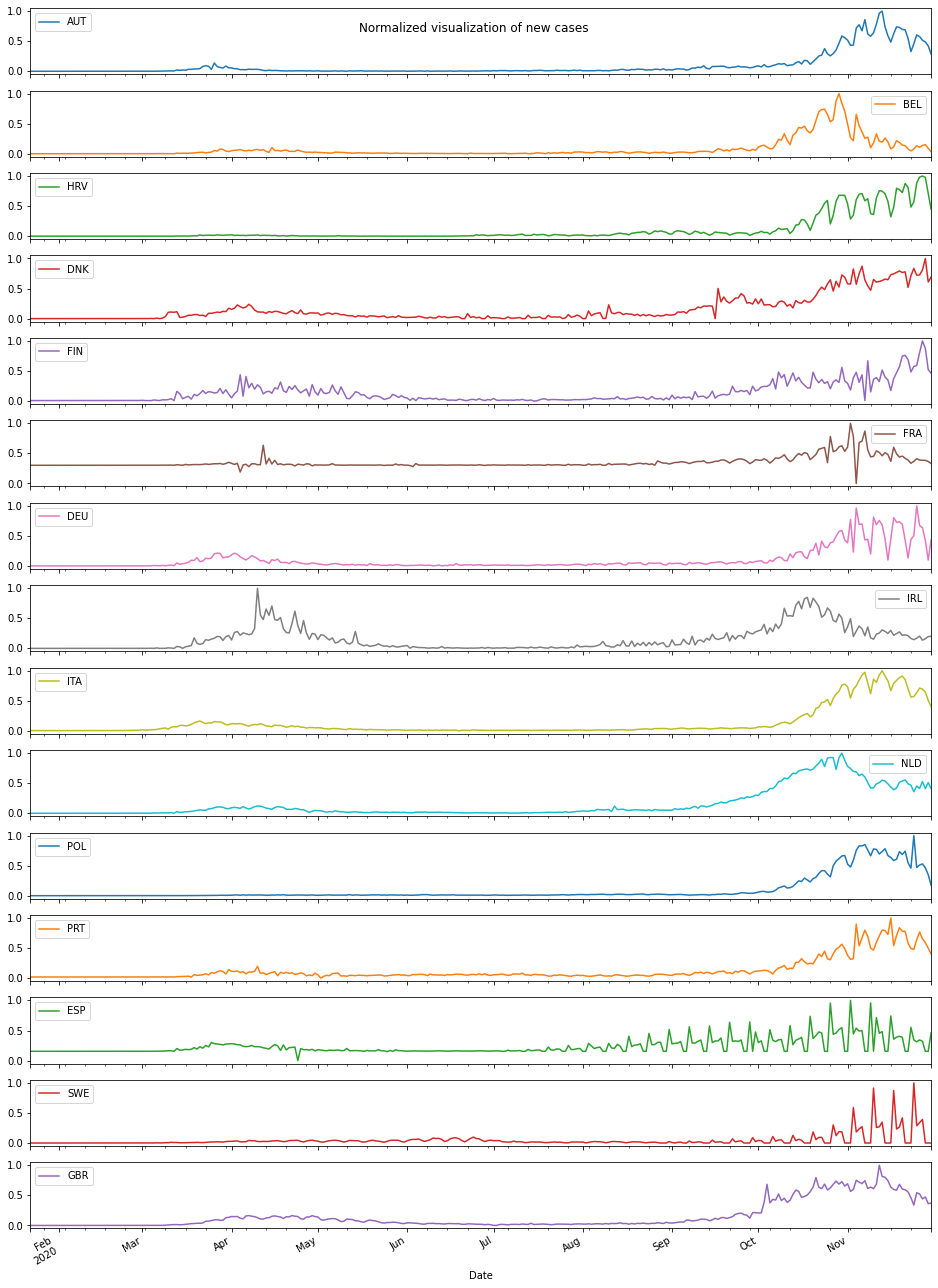

In [14]:
if len(countries_of_interest)<5: 
    figsize=(13,8)
else:
    figsize=(13,18)

df_confirmed_scaled.plot(subplots=True, title='Normalized visualization of new cases', figsize=figsize)
plt.tight_layout()
plt.show()

### Correlation matrix of new cases among different countries

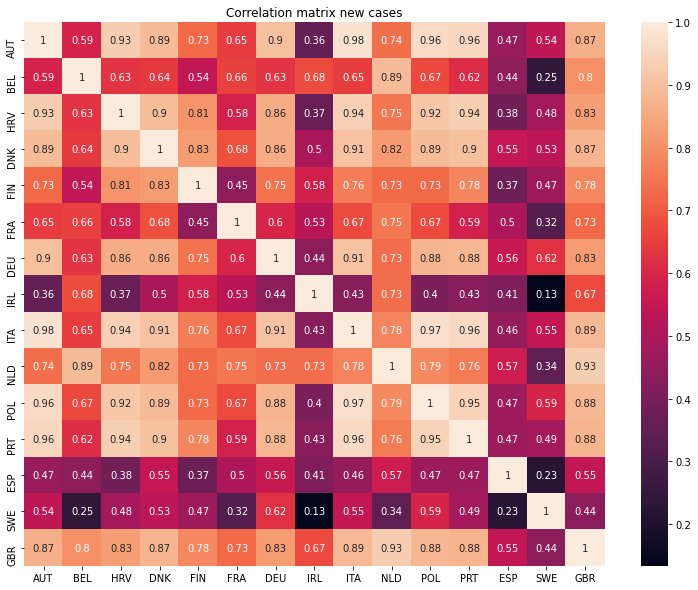

In [15]:
if len(countries_of_interest)<5: 
    figsize=(8,6)
else:
    figsize=(13,10)

corr = df_confirmed_scaled.corr()
plt.figure(figsize=figsize)    
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True)
plt.title('Correlation matrix new cases')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

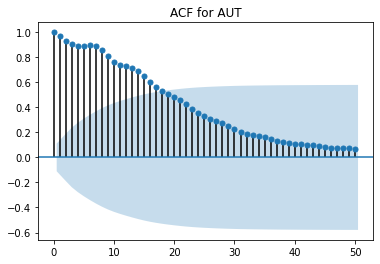

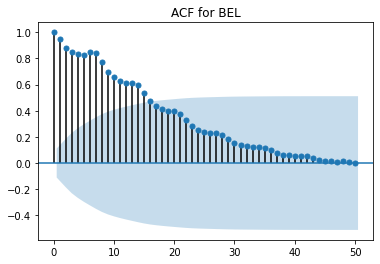

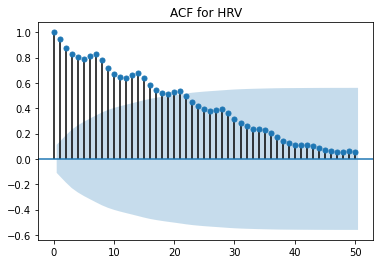

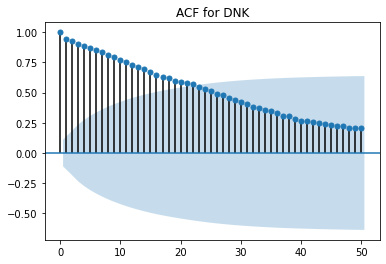

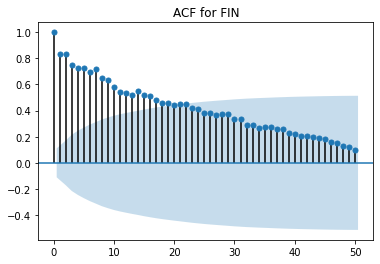

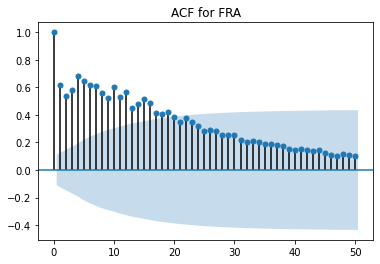

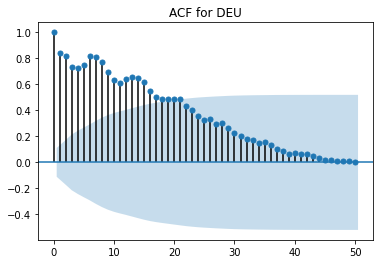

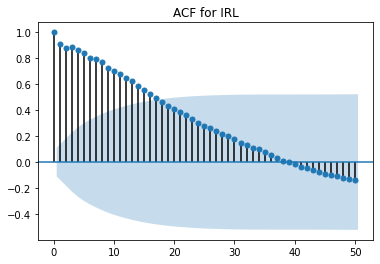

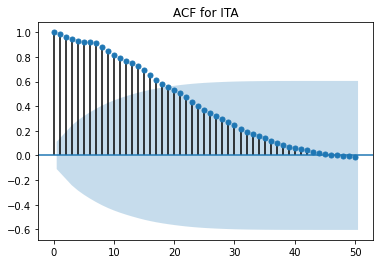

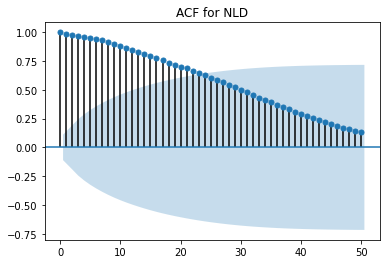

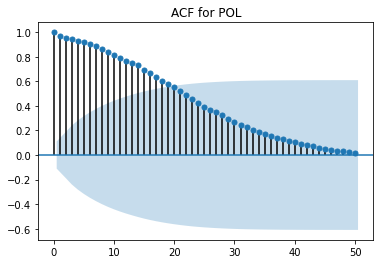

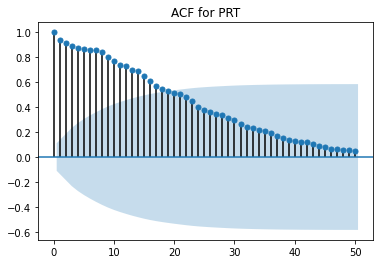

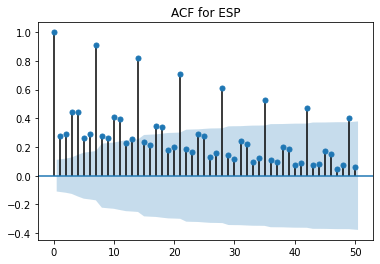

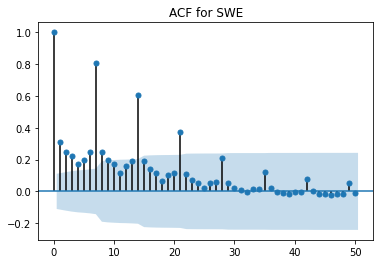

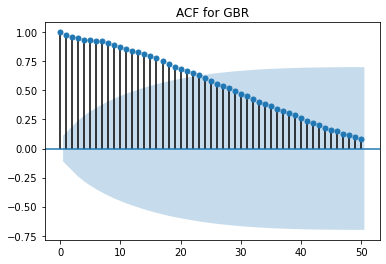

In [16]:
for country in df_confirmed_scaled:
    sm.graphics.tsa.plot_acf(df_confirmed_scaled[country], lags = 50)
    plt.title('ACF for %s' % country)
    plt.show()

STATIONARY TEST: 

 Dickey-Fuller Stationary Test for "AUT" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -0.5052
 No. Lags Chosen      = 16
 Critical value 1%     = -3.453
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 0.891. Weak evidence to reject H0.
 => Series in Non-Stationary


 Dickey-Fuller Stationary Test for "BEL" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -2.3489
 No. Lags Chosen      = 15
 Critical value 1%     = -3.452
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 0.1567. Weak evidence to reject H0.
 => Series in Non-Stationary


 Dickey-Fuller Stationary Test for "HRV" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics     

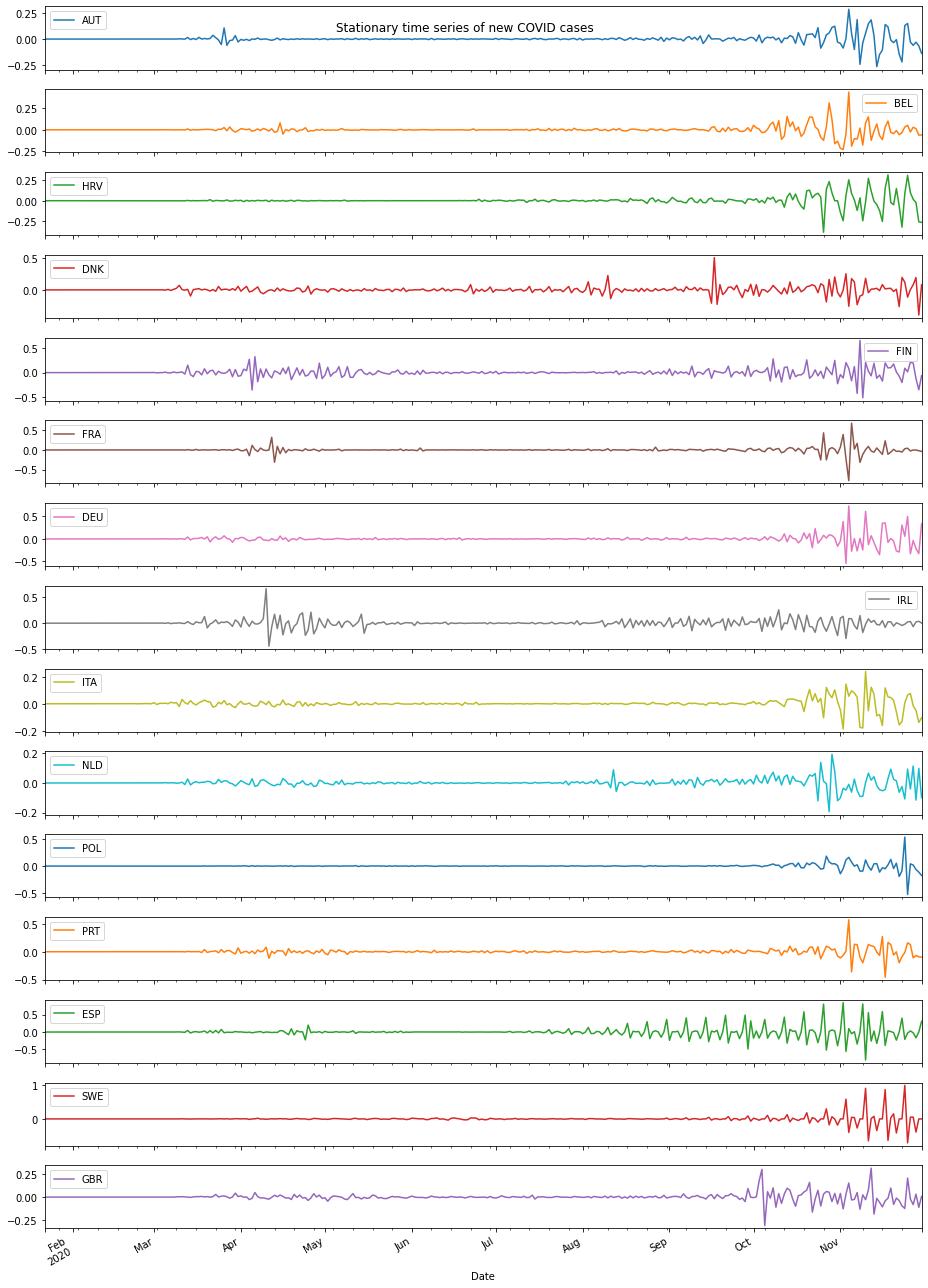


GRANGER CAUSALITY MATRIX: 



,AUT_x,BEL_x,HRV_x,DNK_x,FIN_x,FRA_x,DEU_x,IRL_x,ITA_x,NLD_x,POL_x,PRT_x,ESP_x,SWE_x,GBR_x
AUT_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BEL_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HRV_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DNK_y,0.0,0.0,0.0,0.0,0.009,0.002,0.0,0.012,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FIN_y,0.0,0.0,0.0,0.021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FRA_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DEU_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IRL_y,0.01,0.004,0.006,0.0,0.0,0.012,0.11,0.0,0.024,0.0,0.206,0.249,0.161,0.327,0.055
ITA_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NLD_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001,0.0,0.0,0.0,0.0,0.0,0.0,0.0


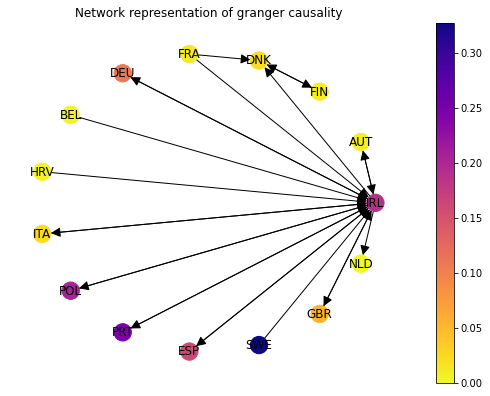

In [17]:
granger_matrix = granger_causality(df_confirmed_scaled, countries_of_interest, 'new COVID cases')